# **Prediksi Hujan Menggunakan Dataset Prakiraan Cuaca BMKG (Multi Wilayah)**

MOUNT GOOGLE DRIVE

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


IMPORT LIBRARY

In [2]:
import requests
import pandas as pd
import numpy as np
import os
import time
from datetime import datetime, timedelta

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

FOLDER OUTPUT

In [3]:
BASE_PATH = "/content/drive/MyDrive/SMT5/BDM/UAS"
os.makedirs(BASE_PATH, exist_ok=True)

print("Folder siap:", BASE_PATH)

Folder siap: /content/drive/MyDrive/SMT5/BDM/UAS


FUNGSI AMBIL DATA BMKG

In [4]:
def fetch_bmkg(adm4):
    url = f"https://api.bmkg.go.id/publik/prakiraan-cuaca?adm4={adm4}"
    response = requests.get(url)
    return response.json()

KOLEKSI DATA

In [5]:
adm4_list = [
    "31.71.01.1001",  # Jakarta Pusat
    "31.72.01.1001",  # Jakarta Utara
    "31.71.03.1001",  # Jakarta Selatan
    "31.71.04.1001",  # Jakarta Timur
    "32.73.01.1001",  # Bandung
    "32.74.01.1001",  # Cimahi
    "33.10.25.1003",  # Klaten
    "34.71.01.1001",  # Yogyakarta
    "35.73.02.1001",  # Surabaya
    "36.71.01.1001",  # Serang
    "51.71.01.1001"   # Denpasar
]

records = []

for adm4 in adm4_list:
    try:
        data = fetch_bmkg(adm4)
        if "data" not in data:
            print(f"[WARNING] Data tidak tersedia untuk ADM4 {adm4}")
            continue

        for area in data["data"]:
            if "cuaca" not in area:
                continue

            for cuaca_harian in area["cuaca"]:
                for cuaca in cuaca_harian:
                    records.append({
                        "datetime": cuaca.get("local_datetime"),
                        "temperature": cuaca.get("t"),
                        "humidity": cuaca.get("hu"),
                        "wind_speed": cuaca.get("ws"),
                        "weather": cuaca.get("weather_desc")
                    })

        time.sleep(1)

    except Exception as e:
        print(f"[ERROR] ADM4 {adm4}: {e}")

df = pd.DataFrame(records)
print("Jumlah data:", df.shape)

Jumlah data: (220, 5)


LABEL HUJAN

In [6]:
df["rain"] = df["weather"].str.contains(
    "Hujan|Thunderstorm|Petir", case=False, na=False
).astype(int)

SIMPAN CSV KE GOOGLE DRIVE

In [7]:
csv_path = f"{BASE_PATH}/dataset_cuaca_bmkg_200plus.csv"
df.to_csv(csv_path, index=False)

print("Dataset berhasil disimpan:", csv_path)

Dataset berhasil disimpan: /content/drive/MyDrive/SMT5/BDM/UAS/dataset_cuaca_bmkg_200plus.csv


In [8]:
# Membaca kembali dataset dari file CSV
df_loaded = pd.read_csv(csv_path)

# Menampilkan informasi dataset
print("Shape dataset:", df_loaded.shape)
df_loaded.head()

Shape dataset: (220, 6)


,datetime,temperature,humidity,wind_speed,weather,rain
0,2026-01-21 13:00:00,28,74,7.0,Hujan Ringan,1
1,2026-01-21 16:00:00,25,86,5.6,Hujan Ringan,1
2,2026-01-21 19:00:00,24,94,8.5,Hujan Ringan,1
3,2026-01-21 22:00:00,24,95,8.7,Hujan Ringan,1
4,2026-01-22 01:00:00,24,96,9.1,Hujan Ringan,1


In [9]:
df_loaded.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 220 entries, 0 to 219
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   datetime     220 non-null    object 
 1   temperature  220 non-null    int64  
 2   humidity     220 non-null    int64  
 3   wind_speed   220 non-null    float64
 4   weather      220 non-null    object 
 5   rain         220 non-null    int64  
dtypes: float64(1), int64(3), object(2)
memory usage: 10.4+ KB


In [10]:
df_loaded.describe()

,temperature,humidity,wind_speed,rain
count,220.000000,220.000000,220.000000,220.000000
mean,24.659091,90.309091,10.705909,0.540909
std,2.308839,6.893509,7.495503,0.499460
min,20.000000,70.000000,0.700000,0.000000
25%,23.000000,87.750000,4.975000,0.000000
50%,24.000000,93.000000,8.700000,1.000000
75%,26.000000,95.000000,15.700000,1.000000
max,33.000000,99.000000,33.500000,1.000000


DATA PREPROCESSING

In [11]:
df["datetime"] = pd.to_datetime(df["datetime"])
df = df.drop_duplicates()
df = df.dropna()

print("Setelah preprocessing:", df.shape)

Setelah preprocessing: (199, 6)


FEATURE ENGINEERING

In [12]:
df["hour"] = df["datetime"].dt.hour
df["day"] = df["datetime"].dt.day
df["month"] = df["datetime"].dt.month

EDA (VISUALISASI)

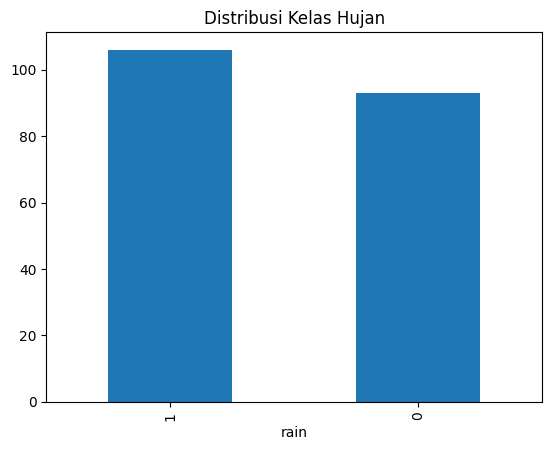

In [13]:
plt.figure()
df["rain"].value_counts().plot(kind="bar")
plt.title("Distribusi Kelas Hujan")
plt.show()

Hasil exploratory data analysis menunjukkan bahwa distribusi kelas hujan relatif seimbang antara kondisi hujan dan tidak hujan. Jumlah data dengan label hujan sedikit lebih dominan dibandingkan tidak hujan, namun perbedaannya tidak signifikan. Kondisi ini menunjukkan bahwa dataset tidak mengalami permasalahan ketidakseimbangan kelas yang berat, sehingga model klasifikasi dapat dilatih tanpa memerlukan teknik penanganan imbalance tambahan. Distribusi kelas yang seimbang juga mendukung evaluasi performa model yang lebih objektif.

SELEKSI FITUR

In [14]:
X = df[["temperature", "humidity", "wind_speed", "hour", "day", "month"]]
y = df["rain"]

selector = SelectKBest(score_func=f_classif, k=4)
X_selected = selector.fit_transform(X, y)

selected_features = X.columns[selector.get_support()]
print("Fitur terpilih:", selected_features)

Fitur terpilih: Index(['temperature', 'humidity', 'wind_speed', 'day'], dtype='object')


/usr/local/lib/python3.12/dist-packages/sklearn/feature_selection/_univariate_selection.py:111: UserWarning: Features [5] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/usr/local/lib/python3.12/dist-packages/sklearn/feature_selection/_univariate_selection.py:112: RuntimeWarning: invalid value encountered in divide
  f = msb / msw


SPLIT DATA

In [15]:
X_train, X_test, y_train, y_test = train_test_split(
    X_selected, y, test_size=0.2, random_state=42
)

In [16]:
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression(max_iter=1000)
lr.fit(X_train, y_train)

y_pred_lr = lr.predict(X_test)

MODELING

In [17]:
model = RandomForestClassifier(
    n_estimators=100,
    random_state=42
)
model.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

EVALUASI MODEL

In [18]:
y_pred = model.predict(X_test)

print("Accuracy :", accuracy_score(y_test, y_pred))
print("Precision:", precision_score(y_test, y_pred))
print("Recall   :", recall_score(y_test, y_pred))
print("F1-score :", f1_score(y_test, y_pred))

Accuracy : 0.5
Precision: 0.4782608695652174
Recall   : 0.5789473684210527
F1-score : 0.5238095238095238


CONFUSION MATRIX

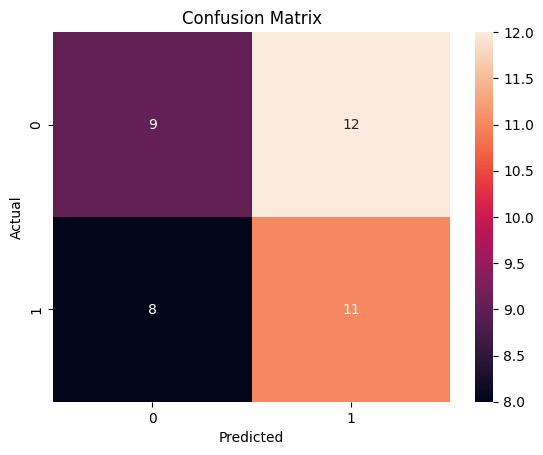

In [19]:
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt="d")
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

MODEL PEMBANDING

In [20]:
from sklearn.tree import DecisionTreeClassifier

dt = DecisionTreeClassifier(random_state=42)
dt.fit(X_train, y_train)

y_pred_dt = dt.predict(X_test)

In [21]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

def evaluate(y_true, y_pred):
    return {
        "Accuracy": accuracy_score(y_true, y_pred),
        "Precision": precision_score(y_true, y_pred),
        "Recall": recall_score(y_true, y_pred),
        "F1-score": f1_score(y_true, y_pred)
    }

comparison = pd.DataFrame.from_dict({
    "Logistic Regression": evaluate(y_test, y_pred_lr),
    "Decision Tree": evaluate(y_test, y_pred_dt),
    "Random Forest": evaluate(y_test, y_pred)
}, orient="index")

comparison

,Accuracy,Precision,Recall,F1-score
Logistic Regression,0.550,0.523810,0.578947,0.550000
Decision Tree,0.575,0.538462,0.736842,0.622222
Random Forest,0.500,0.478261,0.578947,0.523810


Berdasarkan hasil evaluasi tiga model klasifikasi yang digunakan, yaitu Logistic Regression, Decision Tree, dan Random Forest, dapat disimpulkan bahwa Decision Tree merupakan model dengan performa terbaik pada penelitian ini, ditunjukkan oleh nilai accuracy, recall, dan F1-score tertinggi dibandingkan model lainnya. Logistic Regression sebagai model baseline menunjukkan performa yang lebih rendah, mengindikasikan bahwa hubungan antara variabel cuaca dan kejadian hujan tidak sepenuhnya linier. Sementara itu, Random Forest belum mampu memberikan hasil optimal yang diduga disebabkan oleh keterbatasan jumlah data dan fitur, sehingga keunggulan metode ensemble belum dapat dimanfaatkan secara maksimal. Hasil ini menegaskan bahwa pemilihan algoritma yang tepat harus disesuaikan dengan karakteristik data yang digunakan.

SIMPAN MODEL

In [22]:
import joblib

model_path = f"{BASE_PATH}/model_rf_cuaca.pkl"
joblib.dump(model, model_path)

print("Model disimpan:", model_path)

Model disimpan: /content/drive/MyDrive/SMT5/BDM/UAS/model_rf_cuaca.pkl
